# TP BDM : APPLICATIONS SUR NAIVE BAYES 

**Réalisé par : Hayat HACHEMI - SIT 1** 
<br></br>
**Mai 2020**

Durant ce TP , on va exploiter Naive Bayes Algorithm dans deux de ses domains d'applications :
- Analyse des sentiments , 
- Classification de texte .


Naive Bayes classifiers sont une famille de classificateurs probabilistes simples et multiclasses basés sur l'application du théorème de Bayes avec de fortes hypothèses d'indépendance (naïves) entre chaque paire de caractéristiques.

Naive Bayes peut être formé très efficacement. En un seul passage sur les données d'apprentissage, il calcule la distribution de probabilité conditionnelle de chaque caractéristique pour chaque étiquette. Pour la prédiction, il applique le théorème de Bayes pour calculer la distribution de probabilité conditionnelle de chaque étiquette étant donné une observation.

On utilisera Naive Bayes déja imlplémenté sous Spark.ml : https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes .  

**Spark.ml** est un nouveau package introduit dans Spark 1.2, qui vise à fournir un ensemble uniforme d'API de haut niveau qui aident les utilisateurs à créer et à régler des pipelines d'apprentissage automatique pratiques ( practical machine learning pipelines)

**PS: ML est différente de ML lib**

Plus de détails sur machine learning pipelines :  
https://medium.com/analytics-vidhya/what-is-a-pipeline-in-machine-learning-how-to-create-one-bda91d0ceaca  
https://spark.apache.org/docs/2.2.0/ml-pipeline.html

## Initializing Spark

In [1]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc =SparkContext()
sqlContext = SQLContext(sc)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

## Importing Libraries 

In [37]:
import pandas as pd
import seaborn as sns

from pyspark.sql import functions as f
from pyspark.sql.functions import col
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix

# Partie 01 : Prédiction des sentiments à partir des avis sur les vêtements

L'analyse des sentiments est un sujet vital dans le domaine de la PNL ,elle entre dans la grande catégorie des tâches de classification de texte . Le but est de fournir une phrase ou une liste de phrases et un classificateur est censé dire si le sentiment derrière cela est positif, négatif ou neutre. 

**Objectif : Utiliser Naïve Bayes Classification pour prédire les sentiments des clients sur des vêtements d'une société privée à partir de leurs avis**
<br></br>
Dans cette partie de Tp , on va essayer de prédire les sentiments des clients à partir de leurs avis , le dataset utilisée est **« Women's E-Commerce Clothing Reviews »** téléchargeable depuis Kaggle via : https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews .

## Getting Data 

Ce dataset comprend 23486 lignes et 10 feature variables. Chaque ligne correspond à un avis client et comprend les variables:
<br></br>
**Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
<br></br>
**Age**: Positive Integer variable of the reviewers age.
<br></br>
**Title**: String variable for the title of the review.
<br></br>
**Review Text**: String variable for the review body.
<br></br>
**Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
<br></br>
**Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
<br></br>
**Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
<br></br>
**Division Name**: Categorical name of the product high level division.
<br></br>
**Department Name**: Categorical name of the product department name.
<br></br>
**Class Name**: Categorical name of the product class name.

In [4]:
# Load  data
data = sqlContext.read.format('csv').options(header='true', inferschema='true').load('Womens_Clothing_ECommerce_Reviews.csv')

In [5]:
print((data.count(), len(data.columns)))

(26928, 10)


In [6]:
data.printSchema()

root
 |-- Clothing ID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Recommended IND: string (nullable = true)
 |-- Positive Feedback Count: string (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [7]:
data.show(5)

+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|Clothing ID|Age|               Title|         Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|
+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|        767| 33|                null|Absolutely wonder...|     4|              1|                      0|     Initmates|       Intimate| Intimates|
|       1080| 34|                null|"Love this dress!...|     5|              1|                      4|       General|        Dresses|   Dresses|
|       1077| 60|Some major design...|I had such high h...|     3|              0|                      0|       General|        Dresses|   Dresses|
|       1049| 50|    My favorite buy!|I love, love, lov...|     5|              1|                      0|

On remarque que la structuration du dataset n'est pas évidente , pour résoudre le problème j'ai pensé a le lire comme pandas DF puis le retransformer en spark DF

In [8]:
df_c=pd.read_csv("Womens_Clothing_ECommerce_Reviews.csv")

In [9]:
df_c.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
176,895,43,Perfect casual sweater,Love the fit of this sweater! it almost fits l...,5,1,9,General,Tops,Fine gauge
6475,862,51,Beautiful color,The color of this t is beautiful and the shimm...,4,1,0,General Petite,Tops,Knits
22502,867,34,So cute! though inside not soft,I got the cream color and absolutely love the ...,4,1,0,General,Tops,Knits
13757,1078,32,Fell apart before my eyes,Was excited to wear the dress for the first ti...,1,0,0,General,Dresses,Dresses
6403,862,44,NaN,I am so glad i found this tee. as usual i love...,4,1,2,General,Tops,Knits


## Preparing Data 

### Cleaning Data 

Avant d'entamner les analyses , il est nécessaire  de préparer nos donnés afin de les avoir bien rangées . 

Pour les besoins de ce TP , on gardera que les variables : Review Text et Rating

In [ ]:
#conv_list = ['Review Text','Rating']
#data = data.select([column for column in data.columns if column in conv_list])
#data.show(15)

In [10]:
df_ct = df_c[['Review Text','Rating']]

In [ ]:
#Count null values 
#data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

In [11]:
df_ct.isnull().sum()

Review Text    845
Rating           0
dtype: int64

Pour ce TP , on supprimera les valeurs manquantes . Mais dans les cas réels , ce n'est pas toujours le cas 

In [ ]:
#omit null values 
#data_drop=data.dropna('any')

In [12]:
#Delete null values 
df_ct=df_ct.dropna()

In [ ]:
#Count null values 
#data_drop.select([count(when(col(c).isNull(), c)).alias(c) for c in data_drop.columns]).show()

In [13]:
df_ct.isnull().sum()

Review Text    0
Rating         0
dtype: int64

In [14]:
#Convert into spark dataframe 
data = spark.createDataFrame(df_ct)

In [15]:
print((data.count(), len(data.columns)))

(22641, 2)


In [16]:
data.printSchema()

root
 |-- Review Text: string (nullable = true)
 |-- Rating: long (nullable = true)



In [17]:
data.show(15)

+--------------------+------+
|         Review Text|Rating|
+--------------------+------+
|Absolutely wonder...|     4|
|Love this dress! ...|     5|
|I had such high h...|     3|
|I love, love, lov...|     5|
|This shirt is ver...|     5|
|I love tracy rees...|     2|
|I aded this in my...|     5|
|I ordered this in...|     4|
|I love this dress...|     5|
|I'm 5"5' and 125 ...|     5|
|Dress runs small ...|     3|
|This dress is per...|     5|
|More and more i f...|     5|
|Bought the black ...|     5|
|This is a nice ch...|     3|
+--------------------+------+
only showing top 15 rows



### Eploring Data 


#### Analyzing Rating

In [18]:
data.groupBy('Rating').count().show()

+------+-----+
|Rating|count|
+------+-----+
|     5|12540|
|     1|  821|
|     3| 2823|
|     2| 1549|
|     4| 4908|
+------+-----+



#### Building a Sentiment Classifier
<br></br>
Comme nous n'avons pas de colonne qui montre le sentiment : positif ou négatif , j'ai défini une nouvelle colonne de sentiment. Pour ce faire, j'ai supposé que les avis qui avaient une note de 4 ou plus étaient positifs et 2 ou moins étaient négatifs . De plus, je n'ai pas inclus les lignes dont les notes neutres sont égales à 3. 

In [19]:
# Rating of 3 -> neutral (not taken into account)
data_new = data[data['Rating'] != 3]

In [20]:
# Rating of 4 or higher -> positive
# Rating of 2 or lower -> negative 

data_new=data_new.withColumn('Sentiment', f.when(f.col('Rating') >=4, 'True').otherwise('False'))

In [21]:
data_new.printSchema()

root
 |-- Review Text: string (nullable = true)
 |-- Rating: long (nullable = true)
 |-- Sentiment: string (nullable = false)



In [22]:
data_new.show()

+--------------------+------+---------+
|         Review Text|Rating|Sentiment|
+--------------------+------+---------+
|Absolutely wonder...|     4|     True|
|Love this dress! ...|     5|     True|
|I love, love, lov...|     5|     True|
|This shirt is ver...|     5|     True|
|I love tracy rees...|     2|    False|
|I aded this in my...|     5|     True|
|I ordered this in...|     4|     True|
|I love this dress...|     5|     True|
|I'm 5"5' and 125 ...|     5|     True|
|This dress is per...|     5|     True|
|More and more i f...|     5|     True|
|Bought the black ...|     5|     True|
|I took these out ...|     4|     True|
|Took a chance on ...|     5|     True|
|A flattering, sup...|     5|     True|
|I love the look a...|     5|     True|
|If this product w...|     4|     True|
|I'm upset because...|     4|     True|
|First of all, thi...|     2|    False|
|I love this shirt...|     5|     True|
+--------------------+------+---------+
only showing top 20 rows



## Creating Model

### Preparing Pipeline

Spark Machine Learning Pipelines API , elle contient 3 phases :

1-regexTokenizer: Tokenization (with Regular Expression)  
3-stopwordsRemover: Remove Stop Words   
4-countVectors: Count vectors (“document-term vectors”)

In [23]:
#List of stop words 
#Source :https://gist.github.com/sebleier/554280
add_stopwords=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [24]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Review Text", outputCol="words", pattern="\\W")
# stop words
#add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

StringIndexer encode une string colonne de labels en column de label indices. Les indices sont en (0, numLabels), ordonnés par  label frequencies (so the most frequent label gets index 0 ).  
Dan notre cas , the label column (Sentiment) will be encoded to label indices, 0 et 1 

In [25]:
label_stringIdx = StringIndexer(inputCol = "Sentiment", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data_new)
dataset = pipelineFit.transform(data_new)


In [26]:
dataset.show(10)

+--------------------+------+---------+--------------------+--------------------+--------------------+-----+
|         Review Text|Rating|Sentiment|               words|            filtered|            features|label|
+--------------------+------+---------+--------------------+--------------------+--------------------+-----+
|Absolutely wonder...|     4|     True|[absolutely, wond...|[absolutely, wond...|(4507,[23,168,391...|  0.0|
|Love this dress! ...|     5|     True|[love, this, dres...|[love, dress, soo...|(4507,[0,1,6,9,10...|  0.0|
|I love, love, lov...|     5|     True|[i, love, love, l...|[love, love, love...|(4507,[1,7,8,60,1...|  0.0|
|This shirt is ver...|     5|     True|[this, shirt, is,...|[shirt, flatterin...|(4507,[1,7,14,20,...|  0.0|
|I love tracy rees...|     2|    False|[i, love, tracy, ...|[love, tracy, ree...|(4507,[0,1,7,9,10...|  1.0|
|I aded this in my...|     5|     True|[i, aded, this, i...|[aded, basket, ht...|(4507,[2,5,10,12,...|  0.0|
|I ordered this in.

### Splitting Data

In [27]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

In [28]:
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 13886
Test Dataset Count: 5932


### Fitting Model

In [29]:
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)

## Testing & Evaluating Model

### Predictions

In [30]:
predictions = model.transform(testData)

In [31]:
predictions.show(10)

+--------------------+------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|         Review Text|Rating|Sentiment|               words|            filtered|            features|label|       rawPrediction|         probability|prediction|
+--------------------+------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|1. i'm 5'5" tall,...|     4|     True|[1, i, m, 5, 5, t...|[1, m, 5, 5, tall...|(4507,[2,5,6,9,10...|  0.0|[-345.21059663892...|[0.95907934248172...|       0.0|
|5'6" 113lbs purch...|     4|     True|[5, 6, 113lbs, pu...|[5, 6, 113lbs, pu...|(4507,[2,3,5,9,11...|  0.0|[-339.83465802964...|[0.99915185617533...|       0.0|
|A beautiful combi...|     5|     True|[a, beautiful, co...|[beautiful, combi...|(4507,[7,13,16,21...|  0.0|[-243.10403562394...|[0.99999989873624...|       0.0|
|A breath of fresh...|     5

In [32]:
drop_list = ['rawPrediction', 'features']
pred_simpl = predictions.select([column for column in predictions.columns if column not in drop_list])
pred_simpl.show(15)

+--------------------+------+---------+--------------------+--------------------+-----+--------------------+----------+
|         Review Text|Rating|Sentiment|               words|            filtered|label|         probability|prediction|
+--------------------+------+---------+--------------------+--------------------+-----+--------------------+----------+
|1. i'm 5'5" tall,...|     4|     True|[1, i, m, 5, 5, t...|[1, m, 5, 5, tall...|  0.0|[0.95907934248172...|       0.0|
|5'6" 113lbs purch...|     4|     True|[5, 6, 113lbs, pu...|[5, 6, 113lbs, pu...|  0.0|[0.99915185617533...|       0.0|
|A beautiful combi...|     5|     True|[a, beautiful, co...|[beautiful, combi...|  0.0|[0.99999989873624...|       0.0|
|A breath of fresh...|     5|     True|[a, breath, of, f...|[breath, fresh, a...|  0.0|[0.99996259918460...|       0.0|
|A sales associate...|     5|     True|[a, sales, associ...|[sales, associate...|  0.0|[0.99999973269627...|       0.0|
|Absolutely gorgeo...|     5|     True|[

### Confusion Matrice

Une matrice de confusion fournit un résumé  des résultats prédictifs d'un problème de classification. Les prédictions correctes et incorrectes sont résumées dans un tableau avec leurs valeurs et classifiées par classe.


In [33]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [36]:
naive_bayes_cm=confusion_matrix(y_true, y_pred)

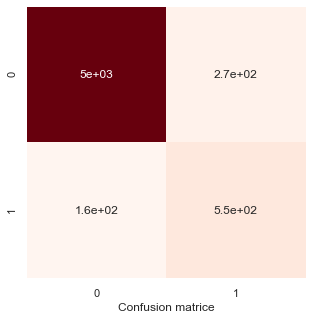

In [38]:
sns.set(rc={'figure.figsize':(5,5)})
p=sns.heatmap(naive_bayes_cm, annot = True, cmap="Reds",cbar=False)
p.axes.xaxis.label.set_text("Confusion matrice")

**Interprétation** :


*Vrai positif*: 5000 résultats sont prédit positif et c'est vrai.

*Vrai négatif*: 550 résultats sont prédit négatif et c'est vrai. 

*Faux positif*(erreur de type 1): 270 résultats sont prédit négatif et c'est faux.

*Faux négatif* (erreur de type 2): 160 résultats sont prédit  positif et c'est faux. 

**-Une bonne prédiction pour les avis positifs** 


### Accuracy Score

In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy sore  = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Accuracy sore  = 0.928355
Test Error = 0.0716453


**On a Accuracy Score= 93% , ce qui signifie que la prédiction de 1 par 10 avis est incorrect, et 9 sont corrects !**

### Classification Report 

Un rapport de classification est utilisé pour mesurer la qualité des prédictions .

In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      5228
         1.0       0.67      0.78      0.72       704

    accuracy                           0.93      5932
   macro avg       0.82      0.86      0.84      5932
weighted avg       0.93      0.93      0.93      5932



**On remarque** que le recall et la précision  des avis positifs (0) est parfaite , la précision pour les avis négatifs et moins bonne (67%) et le rell est tolérable ( 78% > 70 % )

*Pour ne pas oublier : Precision:  When it predicts yes, how often is it correct?.. Recall ( Recall = True Positive Rate ): When it's actually yes, how often does it predict yes?*

# Partie 02 : Prédiction de la classification des documents 

Il existe de nombreuses applications de la classification de texte dans le monde commercial. Par exemple, comme on a vu dans la partie précédente avec l'analyse des sentiments .
Dans la plupart des cas, nos problèmes du monde réel sont beaucoup plus compliqués que cela avec la classification binaire. Et  c'est ce que nous allons faire dans cette partie .

**Objectif : Utiliser Naïve Bayes Classification pour classer les crimes de San Francisco en 39 catégories prédéfinies , « 
San Francisco Crime Classification» ,les données peuvent être téléchargées depuis Kaggle : https://www.kaggle.com/c/sf-crime/data .**

Il s'agit d'un problème de classification de texte multi-classes.



## Getting Data

In [43]:
# Load  data
data_crime = sqlContext.read.format('csv').options(header='true', inferschema='true').load('crime.csv')

In [44]:
data_crime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [45]:
print((data_crime.count(), len(data_crime.columns)))

(878049, 9)


In [46]:
data_crime.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



## Preparing Data

### Cleaning Data

Dna ce TP , on abesoin que de “Descript” et “Category”. 
Exemple :  
- **Input**: Descript ,STOLEN AUTOMOBILE
- **Output**: Category , VEHICLE THEFT


In [47]:
del_list = ['Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
data_crime = data_crime.select([column for column in data_crime.columns if column not in del_list])
data_crime.show(10)

+--------------+--------------------+
|      Category|            Descript|
+--------------+--------------------+
|      WARRANTS|      WARRANT ARREST|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
+--------------+--------------------+
only showing top 10 rows



In [48]:
#Count null values 
data_crime.select([count(when(col(c).isNull(), c)).alias(c) for c in data_crime.columns]).show()

+--------+--------+
|Category|Descript|
+--------+--------+
|       0|       0|
+--------+--------+



### Eploring Data

#### Analyzing categories of crimes

In [49]:
data_crime.groupBy('Category').count().show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|               FRAUD| 16679|
|             SUICIDE|   508|
|SEX OFFENSES FORC...|  4388|
|         LIQUOR LAWS|  1903|
|     SECONDARY CODES|  9985|
|     FAMILY OFFENSES|   491|
|      MISSING PERSON| 25989|
|      OTHER OFFENSES|126182|
|DRIVING UNDER THE...|  2268|
|            WARRANTS| 42214|
|               ARSON|  1513|
|SEX OFFENSES NON ...|   148|
|FORGERY/COUNTERFE...| 10609|
|            GAMBLING|   146|
|             BRIBERY|   289|
|             ASSAULT| 76876|
|         DRUNKENNESS|  4280|
|           EXTORTION|   256|
|                TREA|     6|
|         WEAPON LAWS|  8555|
+--------------------+------+
only showing top 20 rows



## Creating Model


### Preparing Pipeline

In [50]:
# regular expression tokenizer
regexTokenizer_crime = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")
# stop words
stopwordsRemover_crime = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors_crime = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

Dans notre 2 eime cas , the label column (Category) sera encodé label indices , allant de 0 a 32 

In [51]:
label_stringIdx_crime = StringIndexer(inputCol = "Category", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer_crime, stopwordsRemover_crime, countVectors_crime, label_stringIdx_crime])
# Fit the pipeline to training documents.
pipelineFit_crime = pipeline.fit(data_crime)
dataset_crime = pipelineFit_crime.transform(data_crime)

In [52]:
dataset_crime.show(5)

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      Category|            Descript|               words|            filtered|            features|label|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|   [warrant, arrest]|   [warrant, arrest]|(781,[13,26],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(781,[8,13,29],[1...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(781,[8,13,29],[1...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, lo...|(781,[0,1,2,4],[1...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, lo...|(781,[0,1,2,4],[1...|  0.0|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



### Splitting Data 

In [53]:
(trainingData_crime, testData_crime) = dataset_crime.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData_crime.count()))
print("Test Dataset Count: " + str(testData_crime.count()))

Training Dataset Count: 614666
Test Dataset Count: 263383


### Fitting Model

In [54]:
nb_crime = NaiveBayes(smoothing=1)
model_crime = nb_crime.fit(trainingData_crime)

## Testing & evaluating Model

### Predictions

In [55]:
pred_crime = model_crime.transform(testData_crime)

In [57]:
pred_crime.show(15)

+--------+--------+-------+--------+-----------------+-----+--------------------+--------------------+----------+
|Category|Descript|  words|filtered|         features|label|       rawPrediction|         probability|prediction|
+--------+--------+-------+--------+-----------------+-----+--------------------+--------------------+----------+
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.12491829246598...|      27.0|
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.12491829246598...|      27.0|
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.12491829246598...|      27.0|
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.12491829246598...|      27.0|
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.12491829246598...|      27.0|
|   ARSON|   ARSON|[arson]| [arson]|(781,[183],[1.0])| 27.0|[-14.593920355372...|[7.1249

### Confusion Matrice 

In [59]:
y_true_crime = pred_crime.select(['label']).collect()
y_pred_crime = pred_crime.select(['prediction']).collect()

In [69]:
xx=pred_crime.stat.crosstab('label','prediction')

In [70]:
pandas_df = xx.toPandas()

In [71]:
pandas_df

,label_prediction,0.0,1.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,...,35.0,36.0,37.0,38.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.0,52271,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15852,0,0,0,0
2,10.0,0,0,7705,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37.0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
5,25.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,14.0,0,0,0,0,0,0,3047,0,0,...,0,0,0,0,0,0,0,0,0,0
7,20.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,29.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,6,37516,31,14,2,0,0,18,0,...,1,14,4,0,1,184,0,0,0,0


In [66]:
naive_bayes_crime=confusion_matrix(y_true_crime,y_pred_crime)

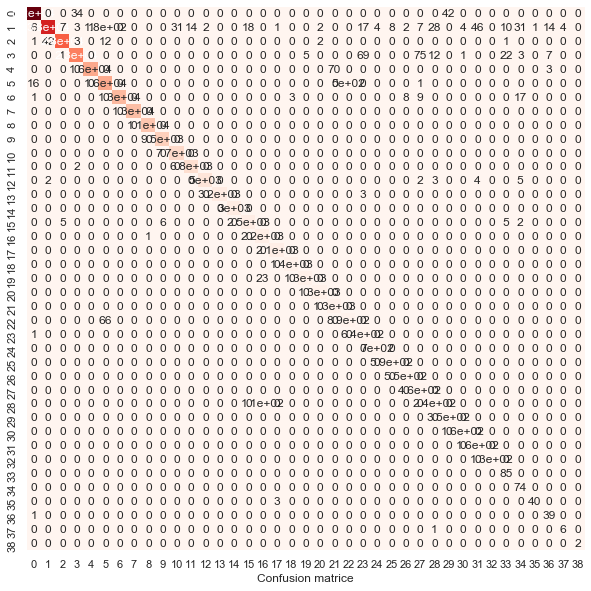

In [61]:
sns.set(rc={'figure.figsize':(10,10)})
p=sns.heatmap(naive_bayes_crime, annot = True, cmap="Reds",cbar=False)
p.axes.xaxis.label.set_text("Confusion matrice")

### Accuracy Score

In [58]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_crime)
print("Accuracy sore  = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Accuracy sore  = 0.993739
Test Error = 0.00626084


### Classification Report

In [73]:
print(classification_report(y_true_crime,y_pred_crime))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52347
         1.0       1.00      0.99      0.99     37961
         2.0       1.00      1.00      1.00     27987
         3.0       1.00      0.99      0.99     22914
         4.0       1.00      1.00      1.00     16045
         5.0       0.98      0.97      0.98     16365
         6.0       1.00      1.00      1.00     13461
         7.0       1.00      1.00      1.00     12589
         8.0       1.00      1.00      1.00     11028
         9.0       1.00      1.00      1.00      9503
        10.0       1.00      1.00      1.00      7705
        11.0       1.00      1.00      1.00      6778
        12.0       1.00      1.00      1.00      4982
        13.0       1.00      1.00      1.00      3191
        14.0       1.00      1.00      1.00      3047
        15.0       0.99      0.99      0.99      2500
        16.0       0.94      1.00      0.97      2249
        17.0       1.00    

**On remarque** que :

Les résultats sont bonnes pour toutes les classes



En réalité , le nombre de classes =33, donc on a 5 classes supplémentaires . Pour cela , au début il faut faire de bon prétraitement afin de ne conserver que les 33 classes 

In [74]:
#Arreter la session 
sc.stop()